In [2]:
import numpy as np
import nengo
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from nengo_bioneurons import BahlNeuron

import copy

Signal definition

In [3]:
def ramp_flat(freq, sine, t):
    # target signal for WM model
    # ramps to +/-1 over 1s, maintains +/-1 for $freq$ s,
    # then ramps to -/+1 over 2s, and stays at -/+1 for $freq$ s
    t_phase = np.mod(t, 2+2*freq)
    if 0 <= t_phase < 1:
        return sine*t_phase
    elif 1 <= t_phase < 1+freq:
        return sine*1
    elif 1+freq <= t_phase < 2+freq:
        return -sine*(t_phase - (1 + freq))
    elif 2+freq <= t_phase <2+2*freq:
        return -sine*1

def ramp_flat_integral(freq, sine, t):
    # a signal that, when integrated, gives 'ramp_flat()' back
    # outputs +/-1 for 1s, 0 for freq, -/+1 for 2s, 0 for freq
    t_phase = np.mod(t, 3+2*freq)
    if 0 <= t_phase < 1:
        return sine
    elif 1 <= t_phase < 1+freq:
        return 0
    elif 1+freq <= t_phase < 3+freq:
        return -sine
    elif 3+freq <= t_phase <3+2*freq:
        return 0

def make_stimulus(signal, freq, sine, seed):       
    if signal == 'cos':
        return nengo.Node(output=lambda t: np.cos(freq*t))
    elif signal == 'sin':
        return nengo.Node(output=lambda t: np.sin(freq*t))
    elif signal == 'ramp':
        return nengo.Node(output=lambda t: freq * (t < 1.0))  # ramp for 1s, cutoff
    elif signal == 'steps':
        return nengo.Node(output=lambda t: -1*(t<1) + 1*(2<t<3) + 1*(4<t<5))
    elif signal == 'ramp_flat':
        return nengo.Node(output=lambda t: ramp_flat(freq, sine, t))
    elif signal == 'ramp_flat_integral':
        return nengo.Node(output=lambda t: ramp_flat_integral(freq, sine, t))
    elif signal == 'white_noise':
        return nengo.Node(nengo.processes.WhiteSignal(
            period=100,
            high=freq,
            rms=0.5,
            seed=seed))

The "supervisor" is a bioneuron population that is identical to the "bio" population being trained in the network. It's job is to provide a set of training spikes to bio which have similar statistics/dynamics to the recurrent spikes that "bio" would produce if it were working properly. That is, the spikes produced by "bio" (and the corresponding spate-space decode) should, after training, resemble those of the "supervisor".

The `supvervisor()` method simulates a feedforward network where the "supervisor" ensemble is driven (via an preliminary spike-generating "pre" LIF() ensemble), with the target signal. "pre" connects onto the specified dendritic section(s) $secs=['tuft']$ with the associated number of synapses $n_{syn}['tuft']$. When the simulation is run, spikes are collected and smoothed with a lowpass filter. Readout decoders are computed from these activities and the appropriately-filtered target signal, with controlled regularization. $reg$ is specified in a dictionary with keys that correspond to how the decoders will be used in the full `simulate()` method:
  - to connect forward from "pre" onto "bio" ($'ff'$)
  - to connect forward from "supervisor" onto "bio" ($sec$)
  
Choose $secs$, $n_{syns}$, and $regs$ such that the weighted spikes sent to "bio" during supervision and during recurrence are as similar as possible. Probably just make them identical, unless there's a compelling reason the recurrent spikes need to be larger/smaller to maintain the same firing rates. 

In [4]:
def supervisor(
    n=10,
    ns=1,
    ss=2,
    es=3,
    cs=4,
    fs=5,
    tau=0.01,
    tau_readout=0.1,
    t=2,
    signal='ramp_flat',
    freq=3,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 1.0, 'ff': 1.0, 'out': 0.1},
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-5e1,5e1),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights')):
        
    with nengo.Network(seed=ns) as model:
        stim = make_stimulus(signal, freq, sine, ss)
        pre = nengo.Ensemble(100, 1,
            neuron_type=nengo.LIF(),
            max_rates=nengo.dists.Uniform(20, 40),  # max_rates of ff similar to "bio"
            seed=es)
        supervisor = nengo.Ensemble(n, 1,
            neuron_type=neuron_type,
            encoders=encoders,
            gain=gain,
            bias=bias,
            seed=es,
            label='supervisor')
        
        nengo.Connection(stim, pre, synapse=None, seed=cs)
        for sec in secs:
            nengo.Connection(pre, supervisor,
                sec=sec,
                n_syn=n_syns[sec],
                syn_type='ExpSyn',
                tau_list=[tau],
                synapse=tau,
                solver=nengo.solvers.LstsqL2(reg=regs['ff']),
                seed=cs)
        p_act = nengo.Probe(supervisor.neurons, synapse=None)
        p_tar = nengo.Probe(stim, synapse=tau)

    with nengo.Simulator(model, seed=ss) as sim:
        sim.run(t)

    lpf = nengo.Lowpass(tau_readout)
    spikes = sim.data[p_act]
    act = lpf.filt(spikes)
    target = lpf.filt(sim.data[p_tar])

    d_supv = {}
    for sec, reg in regs.items():
        solver = nengo.solvers.LstsqL2(reg=regs[sec])
        d_supv[sec] = solver(act, target)[0]

    xhat = np.dot(act, d_supv['out'])
    nrmse = nengolib.signal.nrmse(xhat, target=target)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    rasterplot(sim.trange(), spikes, ax=ax1)
    ax1.set(xlabel='time', ylabel='neuron')
    sns.distplot(np.ravel(act), ax=ax2)
    ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
    ax3.plot(sim.trange(), target, label='target', linestyle='--')
    ax3.plot(sim.trange(), xhat, label='supervisor')
    ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse)
    ax3.legend()
    plt.tight_layout()
    plt.show()
    
    return d_supv

In `simulate`, both the trainig spikes from "supervisor" and the recurrent spikes from "bio" are fed into "bio" through connections built from the passed decoders, $d_{supv}$ and $d_{bios}$. These are used, alongside the randomly distributed encoders and gains, to set the sypantic weight on these bioneuron-to-bioneuron connections. The supervised connection is weighted with a passed transform $T=supv$ ($1$ is full supervision, $0$ is full recurrence), while the recurrent connection is weighted with $T=1-supv$.

Once the simulation is run, spikes are collected and filtered, and a new set of recurrent decoders from the activities, filtered target, and specified regularization values. During the training, $supv$ is transitioned from $1$ to $0$ such that the recurrent spikes gradually take over the responsibility for accurate feedback from the supervisor.

In [5]:
def simulate(
    d_supv,
    d_bios,
    supv,
    n=100,
    ns=1,
    ss=2,
    es=3,
    cs=4,
    fs=5,
    tau=0.1,
    tau_supv=0.01,
    t=2,
    signal='ramp_flat_integral',
    freq=3,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 1.0, 'ff': 1.0, 'out': 0.1},
    encoders=nengo.dists.Uniform(-1e0,1e0),
    gain=nengo.dists.Uniform(-5e1,5e1),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    noise_weights=np.zeros((100, 100, 1)),
    neuron_type=BahlNeuron(bias_method='weights')):

    with nengo.Network(seed=ns) as model:
        stim = make_stimulus(signal, freq, sine, ss)
        nn = make_stimulus('white_noise', freq, sine, ss)
        pre = nengo.Ensemble(100, 1,
            neuron_type=nengo.LIF(),
            max_rates=nengo.dists.Uniform(20, 40),
            seed=es)
        pre2 = nengo.Ensemble(100, 1,
            neuron_type=nengo.LIF(),
            max_rates=nengo.dists.Uniform(20, 40),
            seed=es)
        supervisor = nengo.Ensemble(n, 1, 
            neuron_type=neuron_type,
            encoders=encoders,
            gain=gain,
            bias=bias,
            seed=es,
            label='supervisor')
        bio = nengo.Ensemble(n, 1, 
            neuron_type=neuron_type,
            encoders=encoders,
            gain=gain,
            bias=bias,
            seed=es,
            label='bio')
        noise = nengo.Ensemble(100, 1,
            neuron_type=nengo.LIF(),
            max_rates=nengo.dists.Uniform(20, 40),
            seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)

        nengo.Connection(stim, pre, synapse=None, seed=cs)
        nengo.Connection(stim, pre2, synapse=1/s, seed=cs)
        nengo.Connection(nn, noise, synapse=None, seed=cs)
        for sec in secs:
            nengo.Connection(pre, bio,
                sec=sec,
                n_syn=n_syns[sec],
                syn_type='ExpSyn',
                tau_list=[tau],
                synapse=tau,
                solver=nengo.solvers.LstsqL2(reg=regs['ff']),
                seed=cs)
            nengo.Connection(pre2, supervisor,
                sec=sec,
                n_syn=n_syns[sec],
                syn_type='ExpSyn',
                tau_list=[tau_supv],
                synapse=tau_supv,
                solver=nengo.solvers.LstsqL2(reg=regs['ff']),
                seed=cs)
            nengo.Connection(noise, bio,
                sec='apical',  # sec,
                n_syn=n_syns[sec],
                syn_type='ExpSyn',
                tau_list=[tau],
                synapse=tau,
                syn_weights=noise_weights,
                seed=cs)            
            nengo.Connection(bio, bio,
                sec=sec,
                n_syn=n_syns[sec],
                syn_type='ExpSyn',
                tau_list=[tau],
                synapse=tau,
                transform=1.0-supv,
                solver=nengo.solvers.NoSolver(d_bios[sec]),
                seed=cs)
            nengo.Connection(supervisor, bio,
                sec=sec,
                n_syn=n_syns[sec],
                syn_type='ExpSyn',
                tau_list=[tau],
                synapse=tau,
                transform=supv,
                solver=nengo.solvers.NoSolver(d_supv[sec]),
                seed=cs)
        nengo.Connection(stim, tar, synapse=1/s)
                    
        p_a = nengo.Probe(bio.neurons, synapse=None)
        p_stim = nengo.Probe(stim, synapse=tau)
        p_bio = nengo.Probe(bio, synapse=tau,
            solver=nengo.solvers.NoSolver(d_bios['out']))
        p_supv = nengo.Probe(supervisor, synapse=tau,
            solver=nengo.solvers.NoSolver(d_supv['out']))
        p_tar = nengo.Probe(tar, synapse=tau)

    with nengo.Simulator(model, seed=ss) as sim:
        sim.run(t)

    spikes = sim.data[p_a]
    lpf = nengo.Lowpass(tau)
    act = lpf.filt(spikes)
    target = sim.data[p_tar]
    xhat = sim.data[p_bio]
    xhat_supv = sim.data[p_supv] * supv
    nrmse = nengolib.signal.nrmse(xhat, target=target)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    rasterplot(sim.trange(), spikes, ax=ax1)
    ax1.set(xlabel='time', ylabel='neuron')
    sns.distplot(np.ravel(act), ax=ax2)
    ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
    ax3.plot(sim.trange(), target, label='target', linestyle='--')
    ax3.plot(sim.trange(), xhat, label='bio')
    ax3.plot(sim.trange(), xhat_supv, label='supervisor')
    ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse)
    ax3.legend()
    plt.tight_layout()
    plt.show()

    d_bios_new = {}
    for sec, reg in regs.items():
        solver = nengo.solvers.LstsqL2(reg=regs[sec])
        act = lpf.filt(spikes)
        d_bios_new[sec] = solver(act, target)[0]
    
    return d_bios_new

Find reg/gain/bias regime where feedforward connection activates all neurons, but only to 20-40Hz, leaving room for recurrent connection to strongly affect firing rate and preventing saturation/suicide.

Building finished in 0:00:01.                                                   
Simulating finished in 0:12:00.                                                 


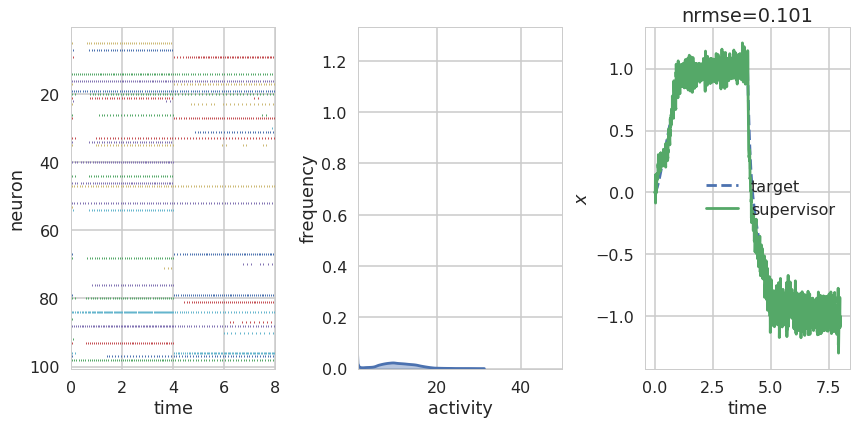

43
Building finished in 0:00:01.                                                   
Simulating finished in 0:12:07.                                                 


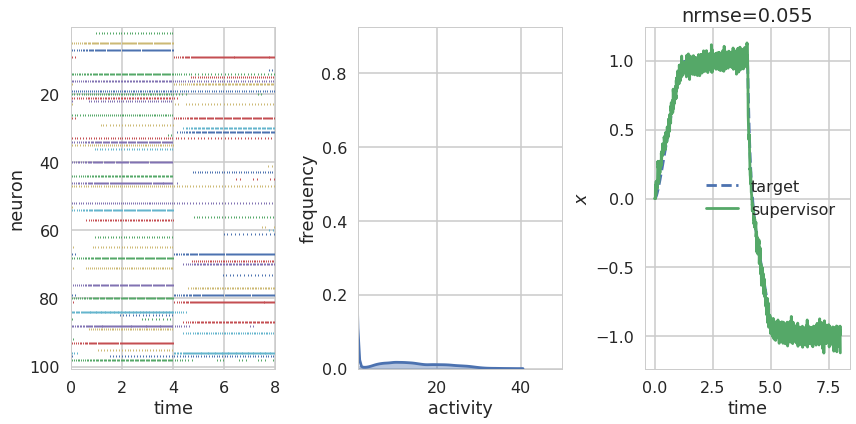

65
Building finished in 0:00:01.                                                   
Simulating finished in 0:12:49.                                                 


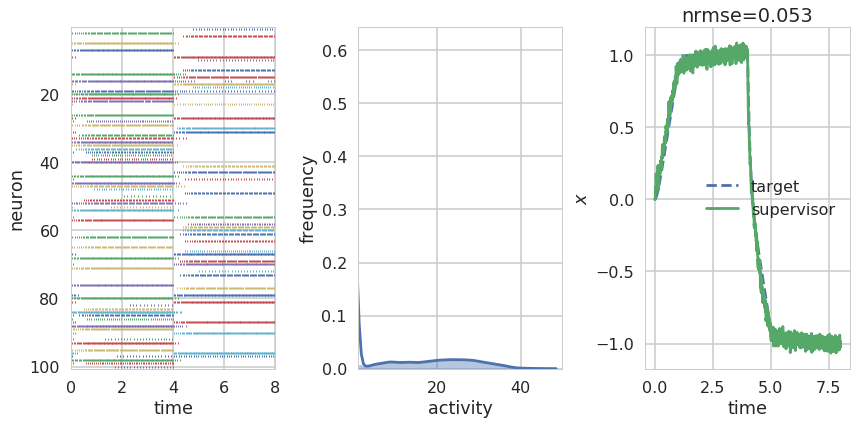

85


In [7]:
# d_supv = supervisor(
#     t=8,
#     n=100,
#     tau=0.01,
#     signal='ramp_flat',
#     freq=3,
#     sine=+1,
#     secs=['tuft'],
#     n_syns={'tuft': 1},
#     regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
#     gain=nengo.dists.Uniform(-1e1, 1e1),
#     bias=nengo.dists.Uniform(-2e-4, 2e-4),
#     neuron_type=BahlNeuron(bias_method='weights'))
# print np.count_nonzero(d_supv['out'])

# d_supv = supervisor(
#     t=8,
#     n=100,
#     tau=0.01,
#     signal='ramp_flat',
#     freq=3,
#     sine=+1,
#     secs=['tuft'],
#     n_syns={'tuft': 1},
#     regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
#     gain=nengo.dists.Uniform(-3e1, 3e1),
#     bias=nengo.dists.Uniform(-2e-4, 2e-4),
#     neuron_type=BahlNeuron(bias_method='weights'))
# print np.count_nonzero(d_supv['out'])

# d_supv = supervisor(
#     t=8,
#     n=100,
#     tau=0.01,
#     signal='ramp_flat',
#     freq=3,
#     sine=+1,
#     secs=['tuft'],
#     n_syns={'tuft': 1},
#     regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
#     gain=nengo.dists.Uniform(-1e2, 1e2),
#     bias=nengo.dists.Uniform(-2e-4, 2e-4),
#     neuron_type=BahlNeuron(bias_method='weights'))
# print np.count_nonzero(d_supv['out'])

Start playing with $gain$, $bias$, and $reg$ parameters to find feedforward and supervisor signals of reasonable magnitudes

Building finished in 0:00:02.                                                   
Simulating finished in 0:05:04.                                                 


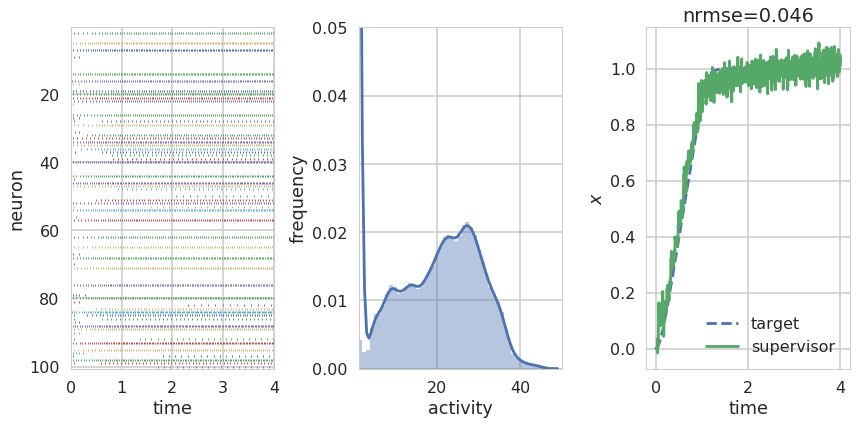

[####################### Building... 52%                        ] ETA: 0:00:01

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Building finished in 0:00:02.                                                   
Simulating finished in 0:13:36.                                                 


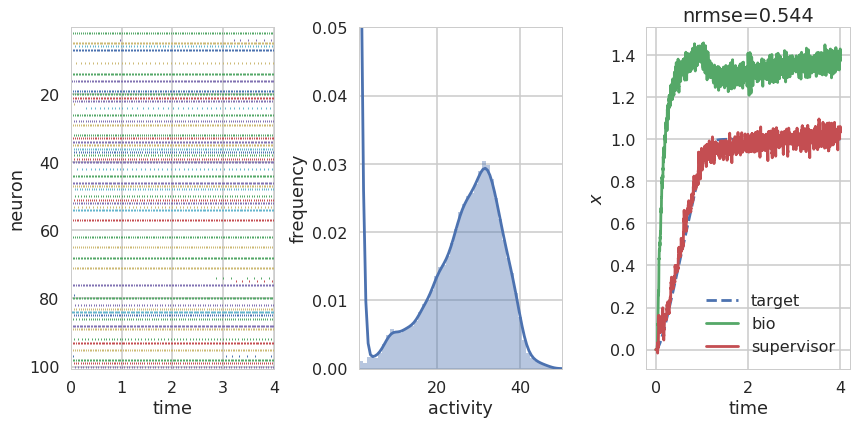

Building finished in 0:00:02.                                                   
Simulating finished in 0:14:06.                                                 


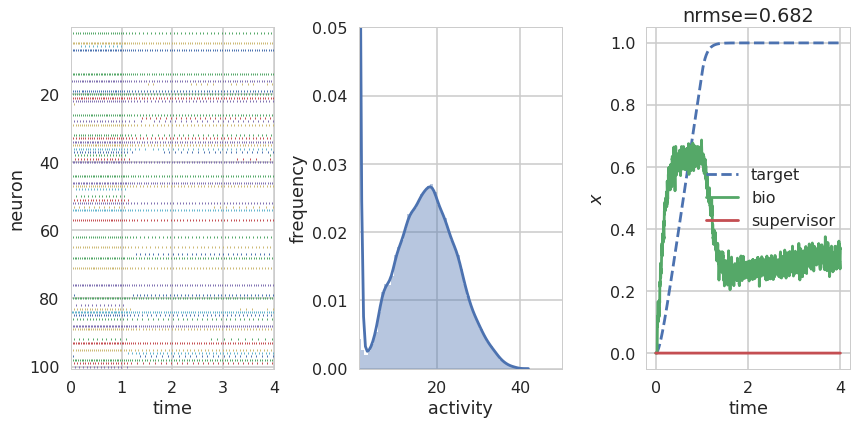

In [5]:
d_supv = supervisor(
    t=4,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=3,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=+1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [+1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

supervisor signal is too strong, which makes recurrent signal too weak once supervisor has been removed, leading to underestimation. Try increasing $regs['tuft']$ on supervisor.

Building finished in 0:00:01.                                                   
Simulating finished in 0:05:27.                                                 


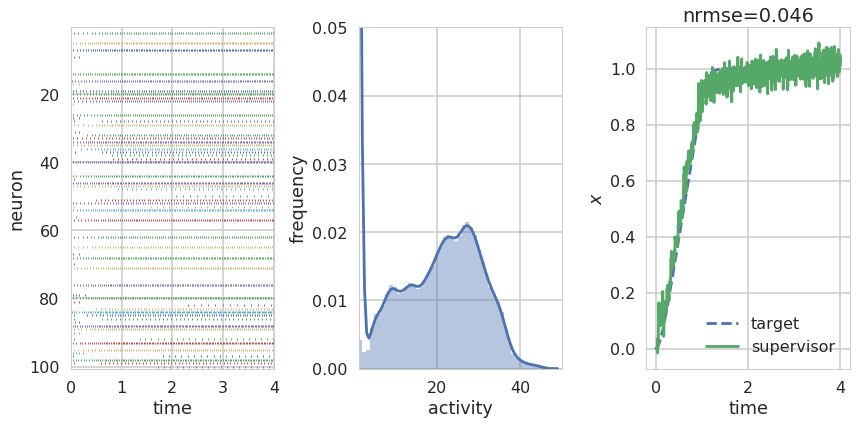

Building finished in 0:00:02.                                                   
Simulating finished in 0:15:01.                                                 


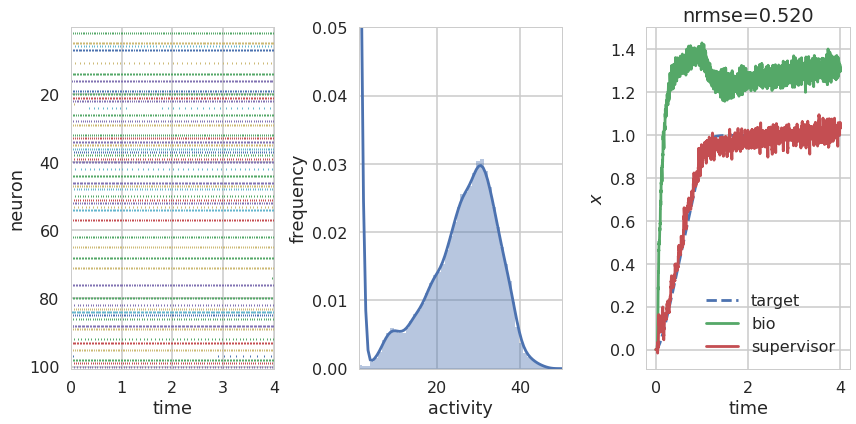

Building finished in 0:00:02.                                                   
Simulating finished in 0:15:39.                                                 


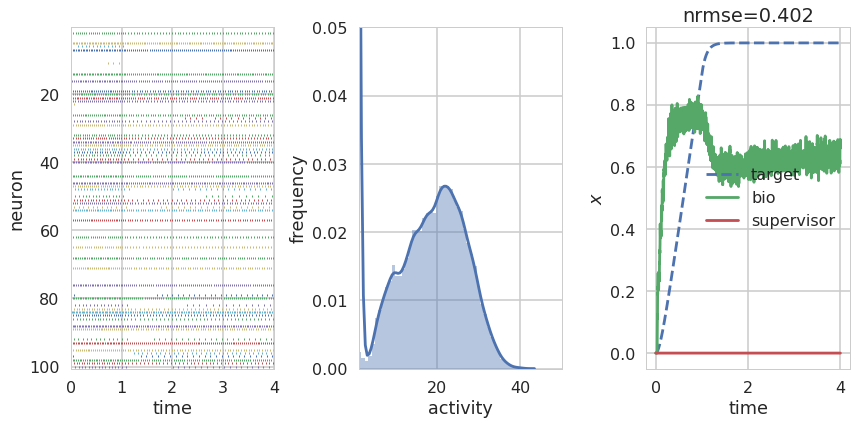

In [6]:
d_supv = supervisor(
    t=4,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=3,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 1.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=+1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [+1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Better, but supervisor is still too strong

Building finished in 0:00:01.                                                   
Simulating finished in 0:05:11.                                                 


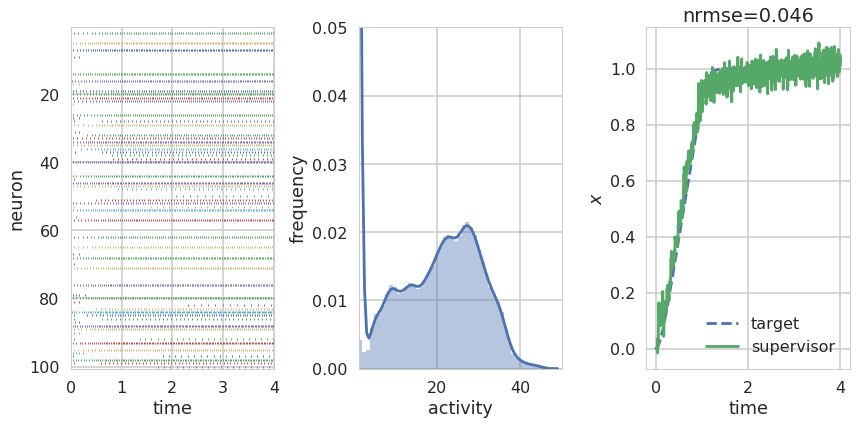

[####################### Building... 57%                        ] ETA: 0:00:01

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Building finished in 0:00:02.                                                   
Simulating finished in 0:13:46.                                                 


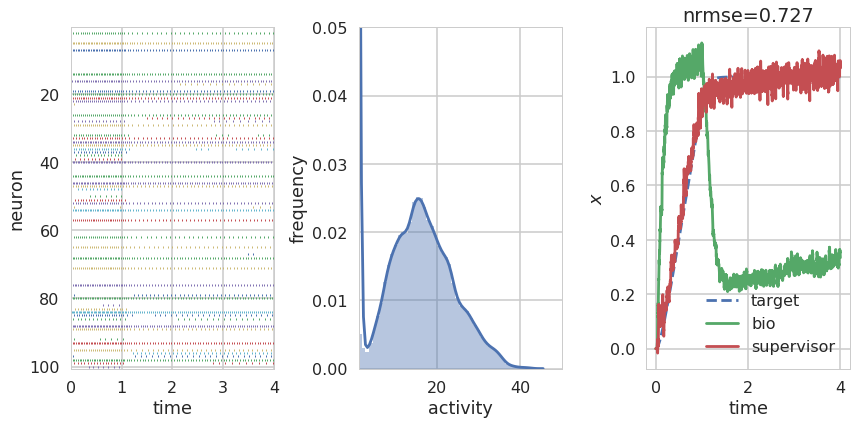

Building finished in 0:00:02.                                                   
Simulating finished in 0:14:14.                                                 


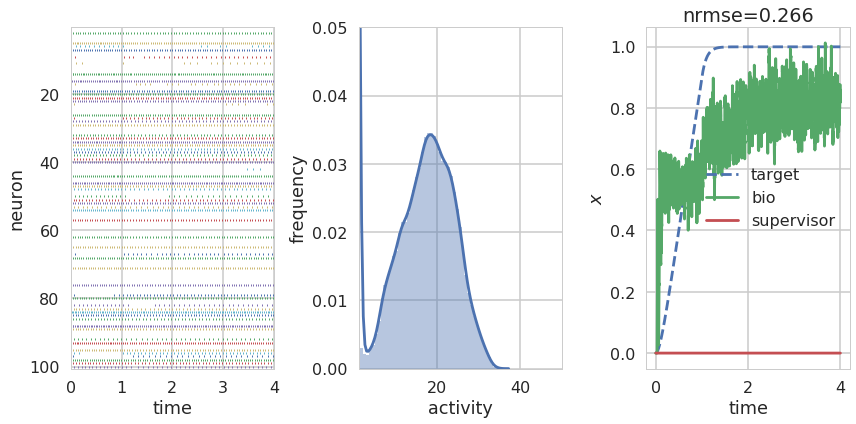

In [5]:
d_supv = supervisor(
    t=4,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=3,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 10.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=+1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [+1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 0.1, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Now it's too weak, but the recurrence is beginning to properly take over once supervisor is removed

Building finished in 0:00:01.                                                   
Simulating finished in 0:05:23.                                                 


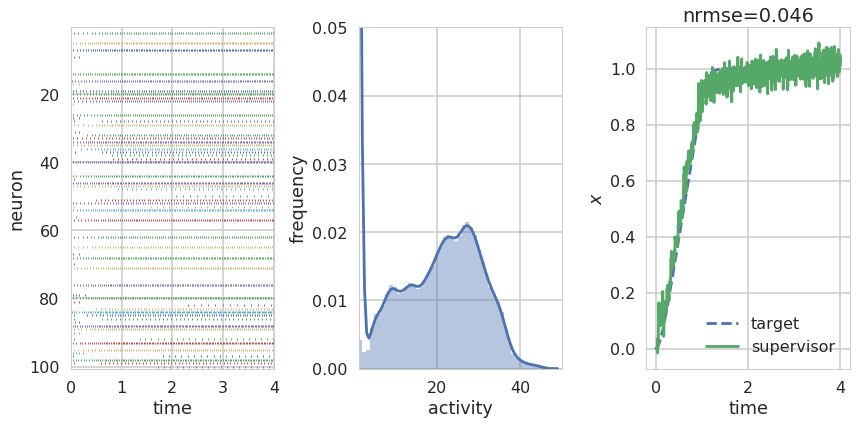

Building finished in 0:00:02.                                                   
Simulating finished in 0:14:37.                                                 


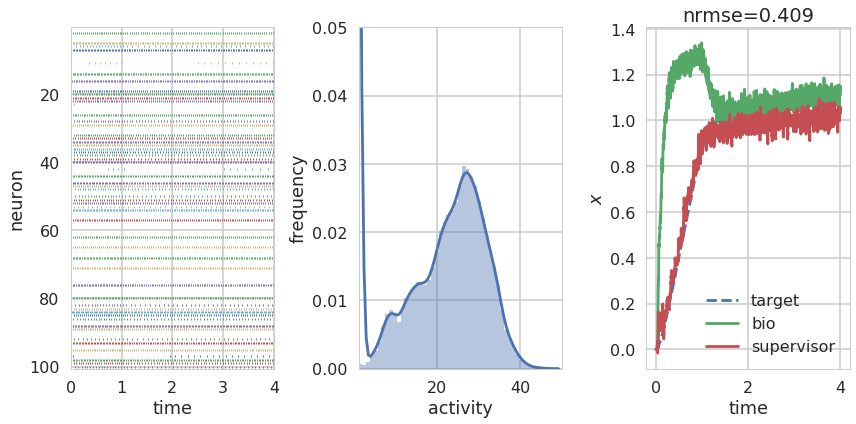

Building finished in 0:00:02.                                                   
Simulating finished in 0:14:55.                                                 


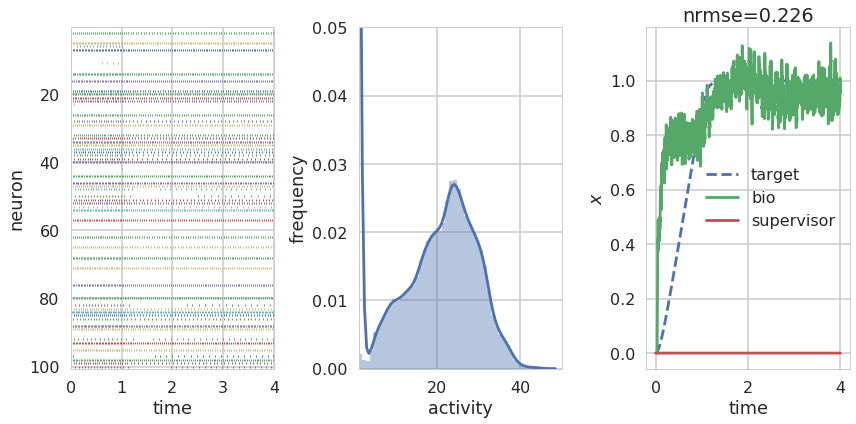

In [6]:
d_supv = supervisor(
    t=4,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=3,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=+1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 1.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [+1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 1.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Closer, although there's still that overshoot before $t=1$

Building finished in 0:00:01.                                                   
Simulating finished in 0:05:44.                                                 


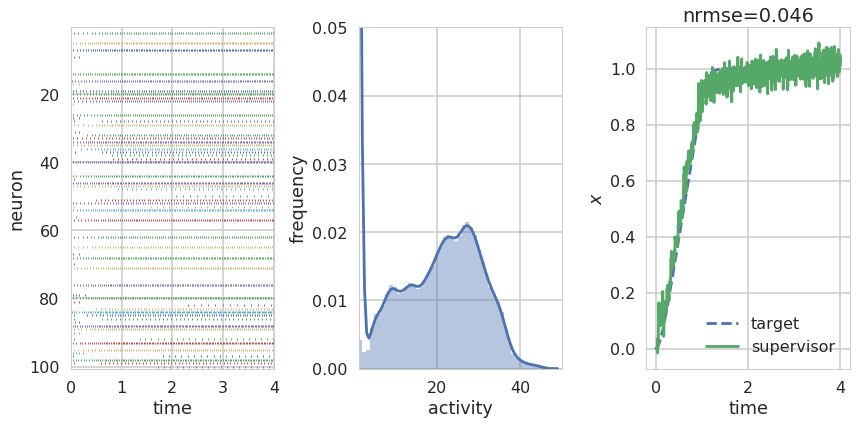

Building finished in 0:00:02.                                                   
Simulating finished in 0:15:04.                                                 


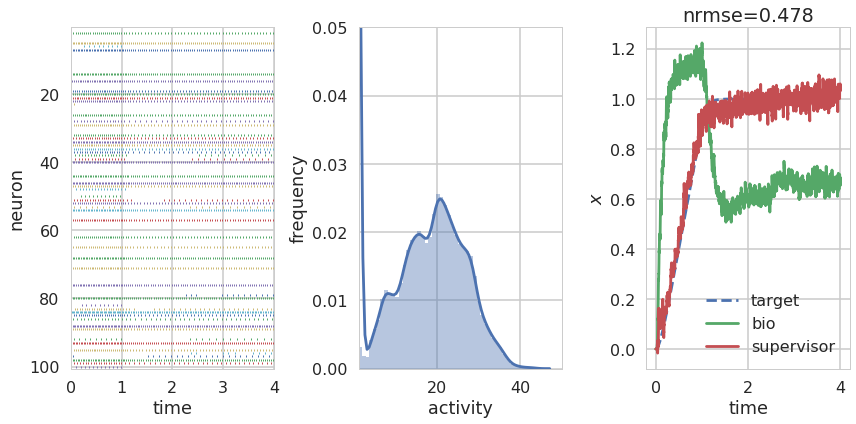

Building finished in 0:00:02.                                                   
Simulating finished in 0:15:38.                                                 


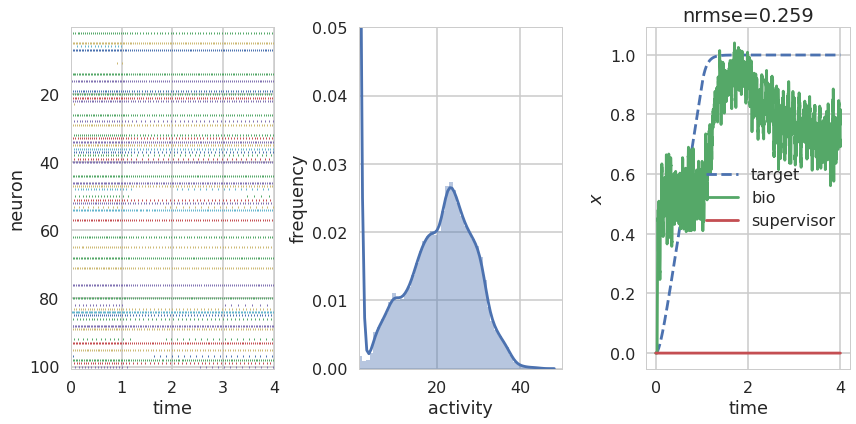

In [7]:
d_supv = supervisor(
    t=4,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=3,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 6.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=+1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 2.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [+1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=4,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=3,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 2.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Building finished in 0:00:01.                                                   
Simulating finished in 0:13:48.                                                 


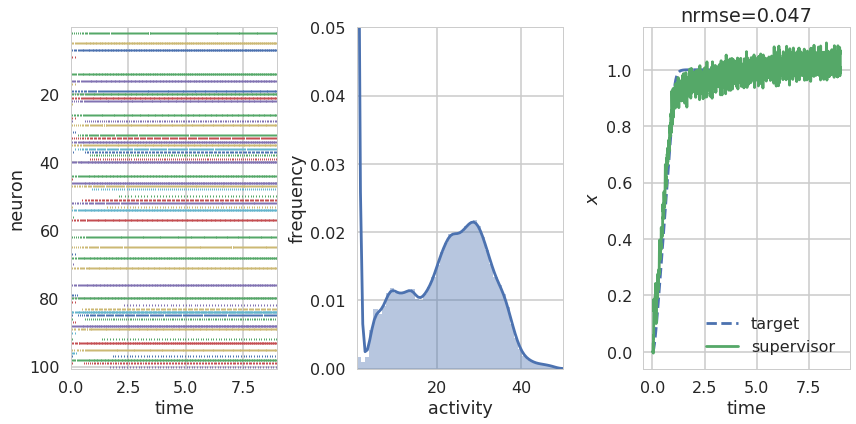

Building finished in 0:00:02.                                                   
Simulating finished in 0:36:39.                                                 


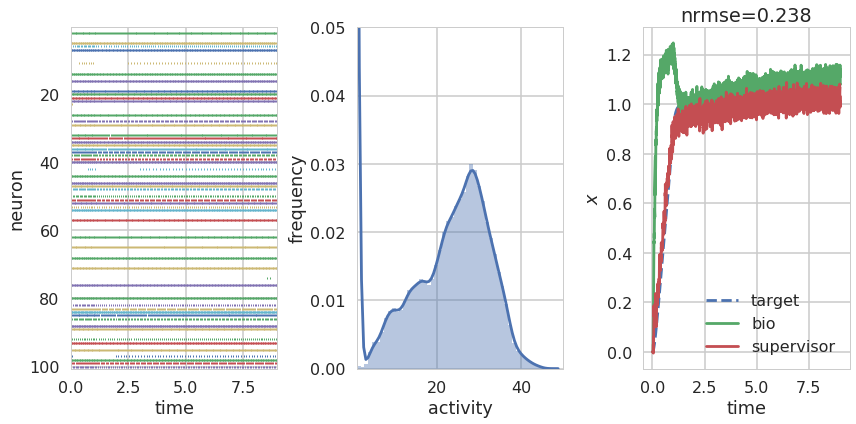

Building finished in 0:00:02.                                                   
Simulating finished in 0:36:15.                                                 


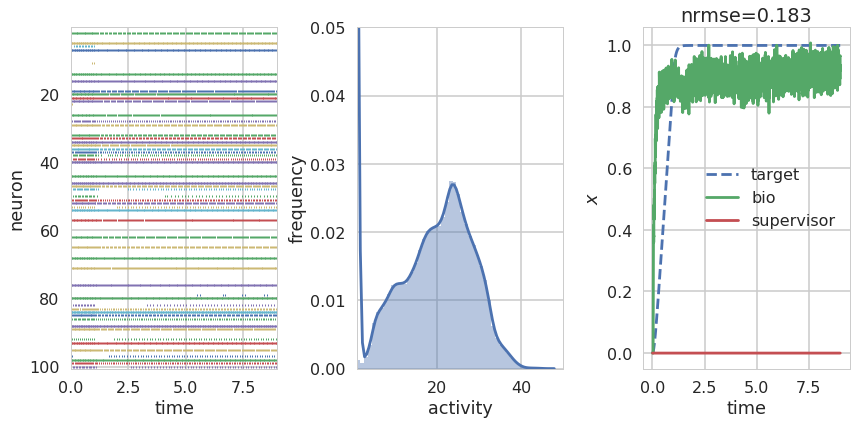

In [8]:
d_supv = supervisor(
    t=9,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=+1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 2.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [+1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 2.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Nicely stable result for the positive ramp. Will the same parameters/procedure work for the negative ramp?

Building finished in 0:00:01.                                                   
Simulating finished in 0:14:07.                                                 


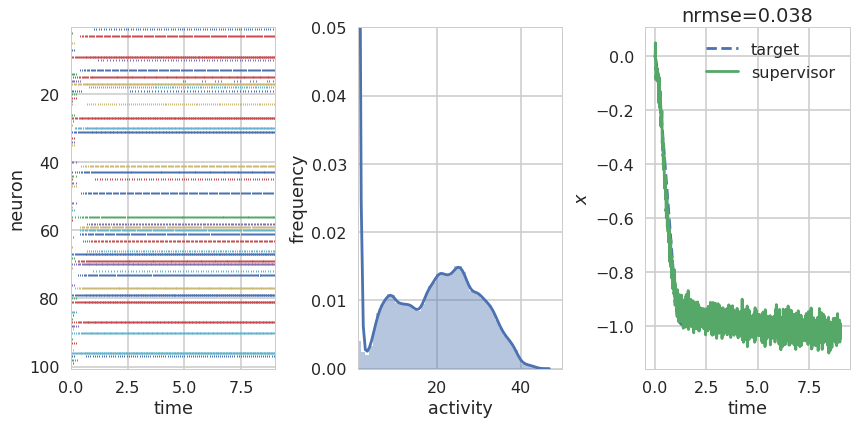

Building finished in 0:00:02.                                                   
Simulating finished in 0:35:40.                                                 


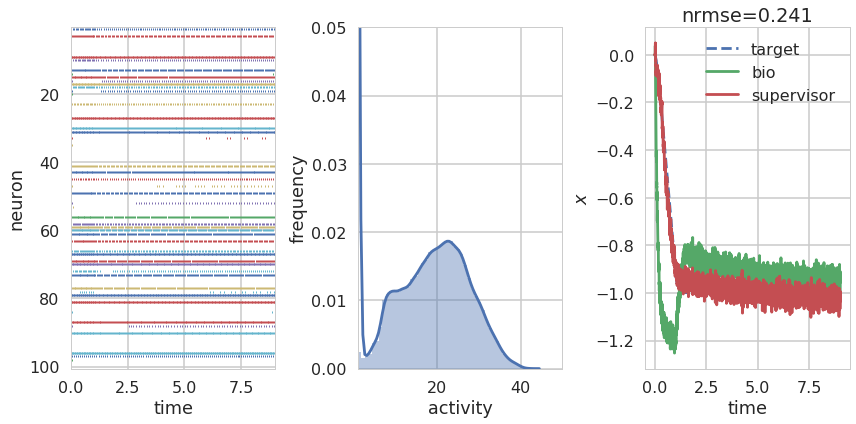

Building finished in 0:00:02.                                                   
Simulating finished in 0:38:19.                                                 


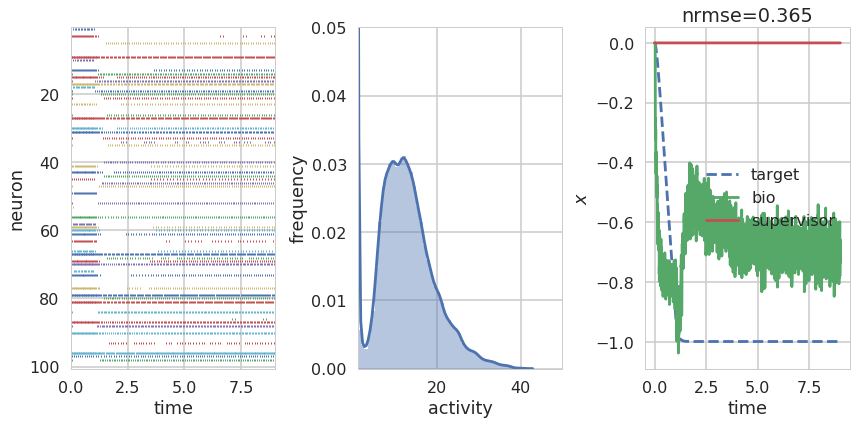

In [9]:
d_supv = supervisor(
    t=9,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=8,
    sine=-1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=-1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [-1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Works pretty well, but not perfectly, for the negative ramp. Larger number of bioneurons $n$ would likely reduce the discrepancy between positive and negative ramps (WM model has $n=1000$, here it's $n=100$)

Building finished in 0:00:01.                                                   
Simulating finished in 0:30:34.                                                 


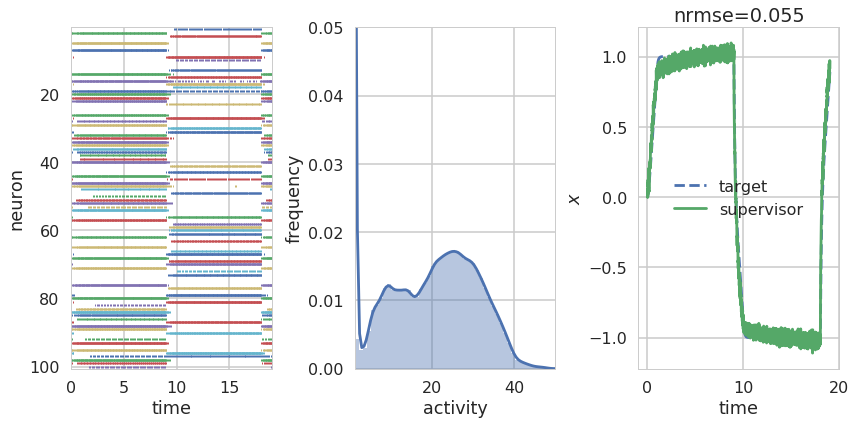

Building finished in 0:00:02.                                                   
Simulating finished in 1:16:32.                                                 


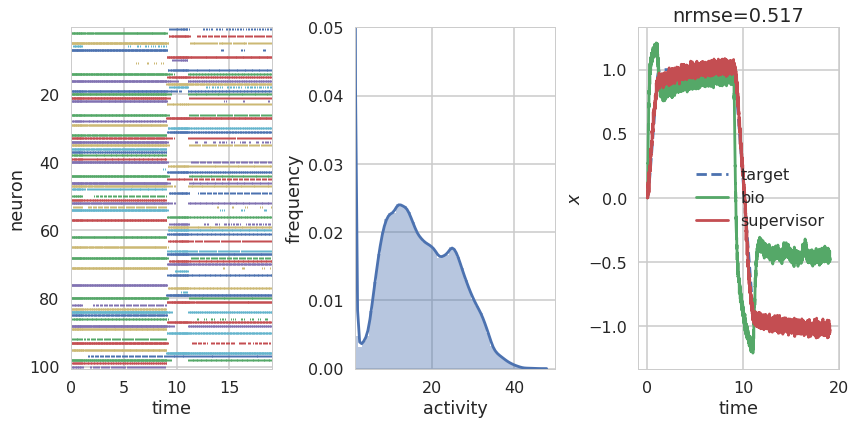

Building finished in 0:00:02.                                                   
Simulating finished in 0:37:22.                                                 


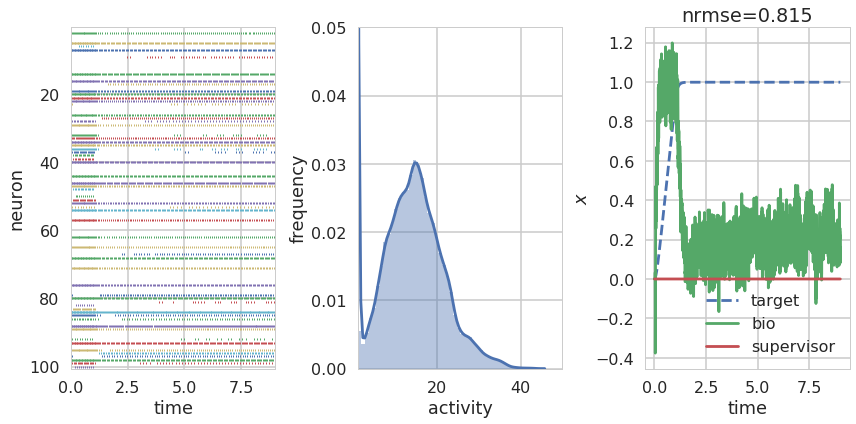

Building finished in 0:00:02.                                                   
Simulating finished in 0:36:42.                                                 


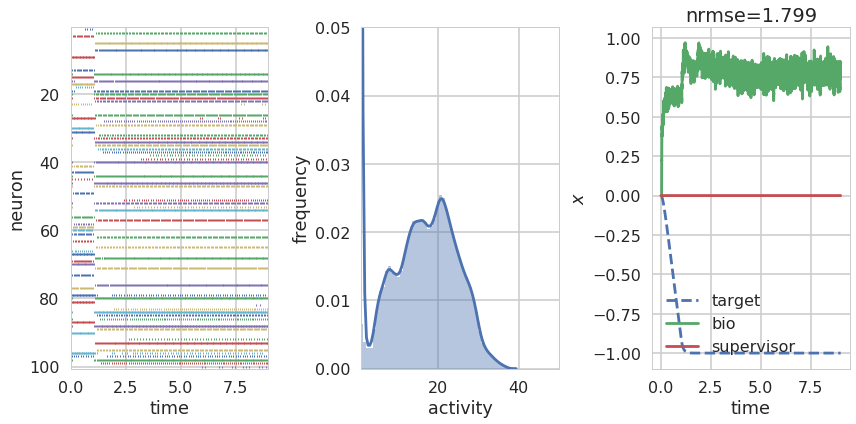

In [10]:
d_supv = supervisor(
    t=19,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=19,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=+1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [+1, -1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Interestingly, training on both a positive and negative ramp in the same simulation does not train the recurrent decoders well, at least not without a more gradual transition.

Building finished in 0:00:01.                                                   
Simulating finished in 0:14:14.                                                 


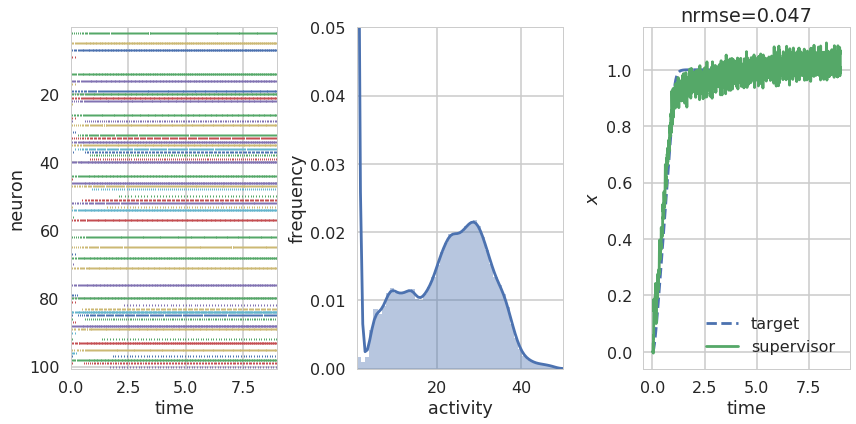

Building finished in 0:00:02.                                                   
Simulating finished in 0:37:58.                                                 


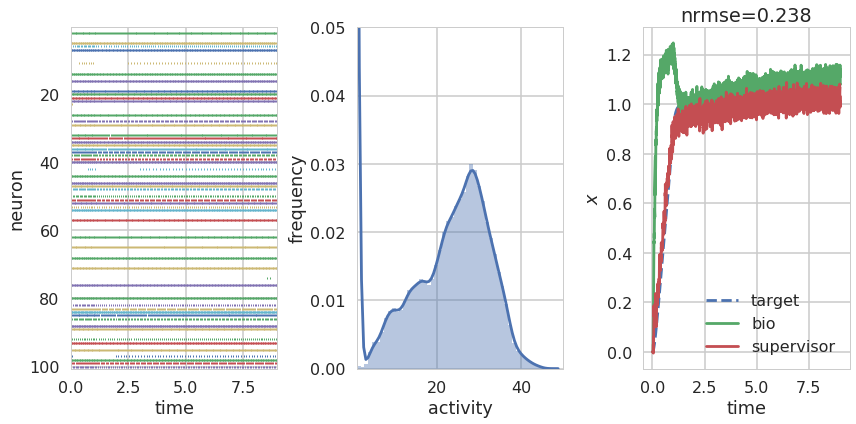

Building finished in 0:00:02.                                                   
Simulating finished in 0:42:53.                                                 


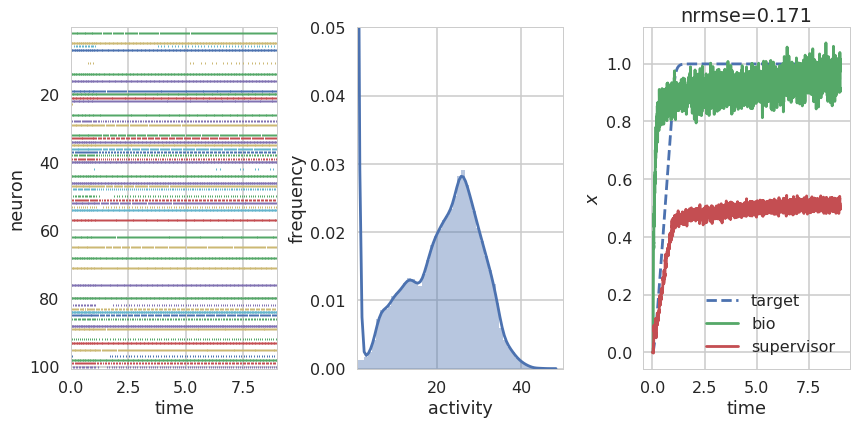

Building finished in 0:00:02.                                                   
Simulating finished in 0:39:17.                                                 


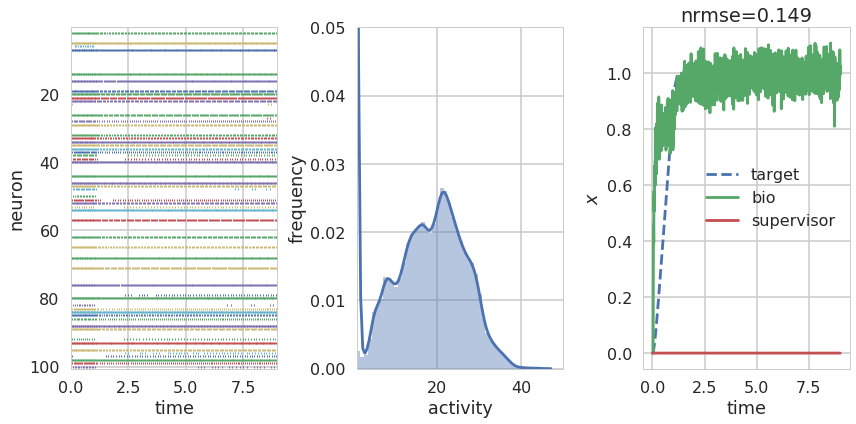

Building finished in 0:00:02.                                                   
Simulating finished in 0:40:41.                                                 


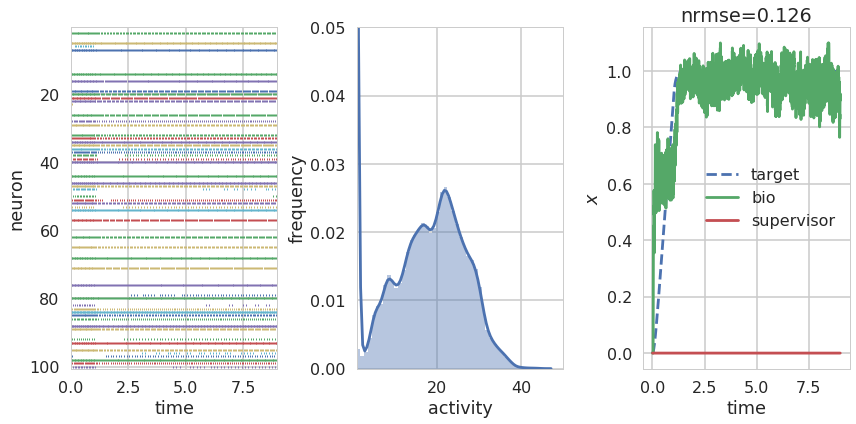

In [11]:
d_supv = supervisor(
    t=9,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0, 0.5, 0.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=+1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [+1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Introducing an intermediate $supv=0.5$ point has increased stability/accuracy of final unsupervised simulation

Building finished in 0:00:01.                                                   
Simulating finished in 0:14:45.                                                 


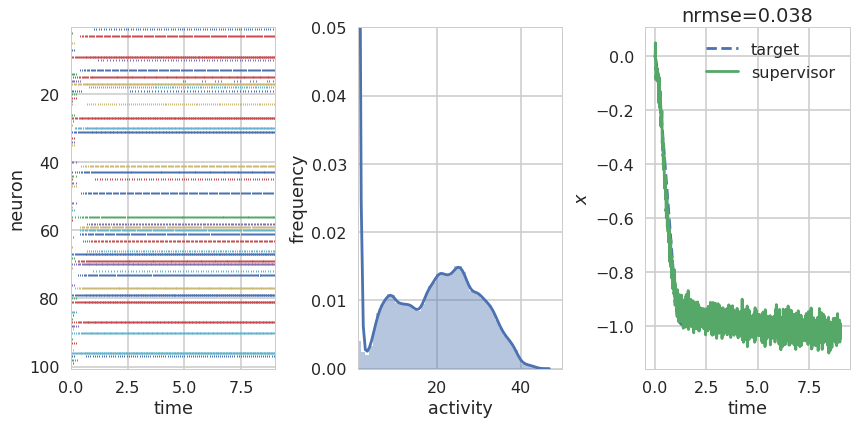

Building finished in 0:00:02.                                                   
Simulating finished in 0:38:25.                                                 


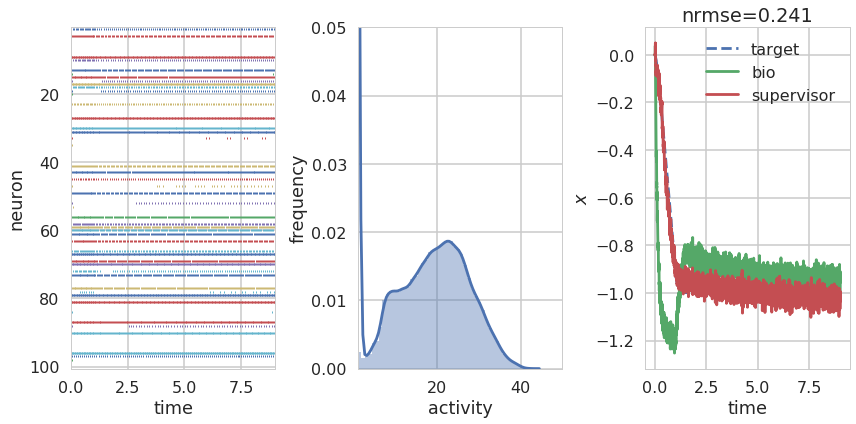

Building finished in 0:00:02.                                                   
Simulating finished in 0:38:02.                                                 


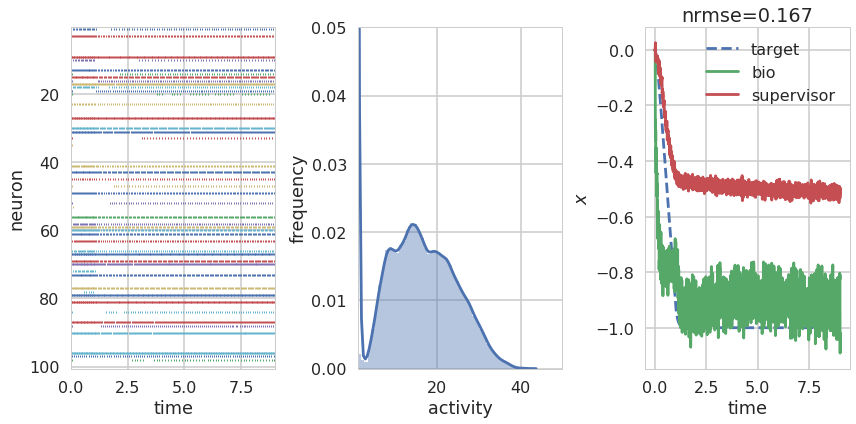

Building finished in 0:00:02.                                                   
Simulating finished in 0:41:05.                                                 


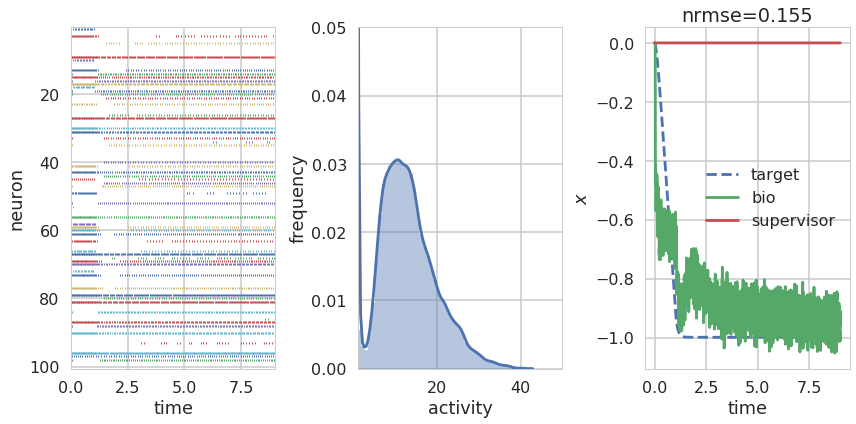

Building finished in 0:00:02.                                                   
Simulating finished in 0:37:25.                                                 


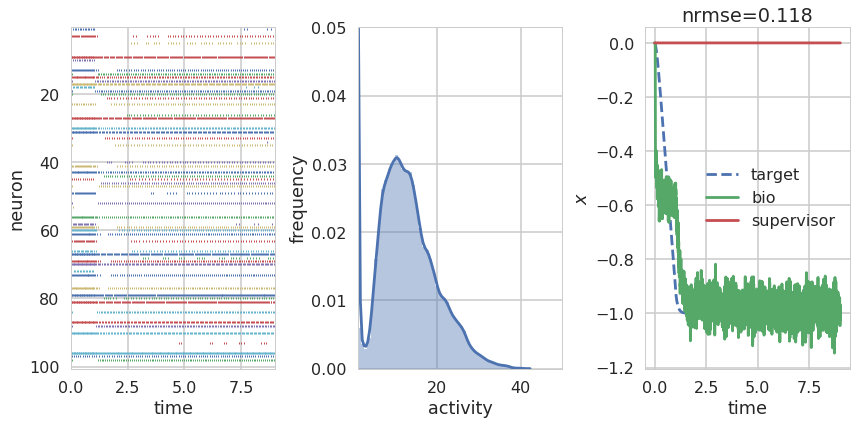

In [12]:
d_supv = supervisor(
    t=9,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=8,
    sine=-1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0, 0.5, 0.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=-1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [-1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Intermediate $supv$ also helps reduce positive/negative ramp discrepancy

Simulate with noise-induced spikes from a LIF() population into "bio"

noise section is 'apical'

add $T=1.0-supv$ to recurrent connection

Building finished in 0:00:01.                                                   
Simulating finished in 0:11:55.                                                 


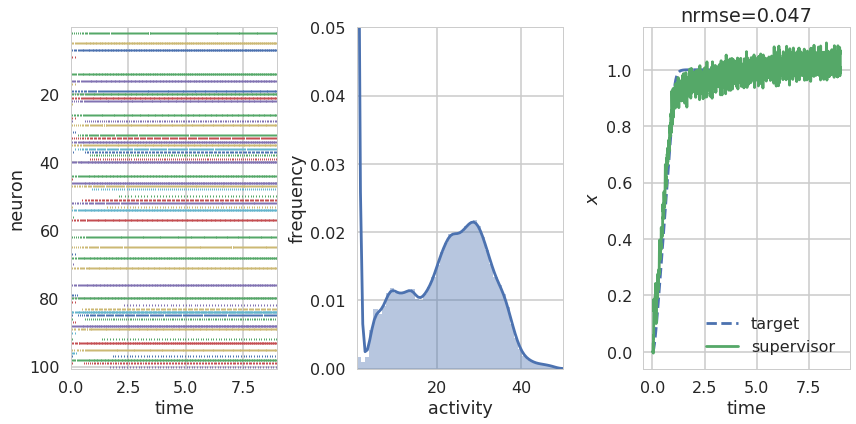

[####################### Building... 56%                        ] ETA: 0:00:01

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Building finished in 0:00:02.                                                   
Simulating finished in 0:33:31.                                                 


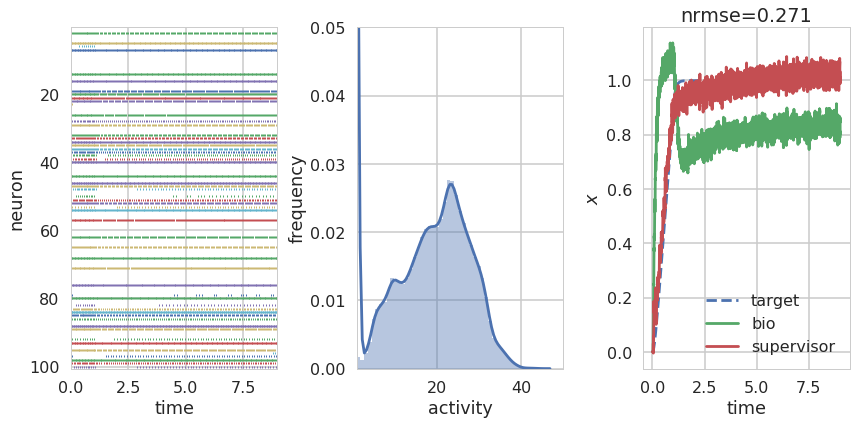

Building finished in 0:00:02.                                                   
Simulating finished in 0:34:40.                                                 


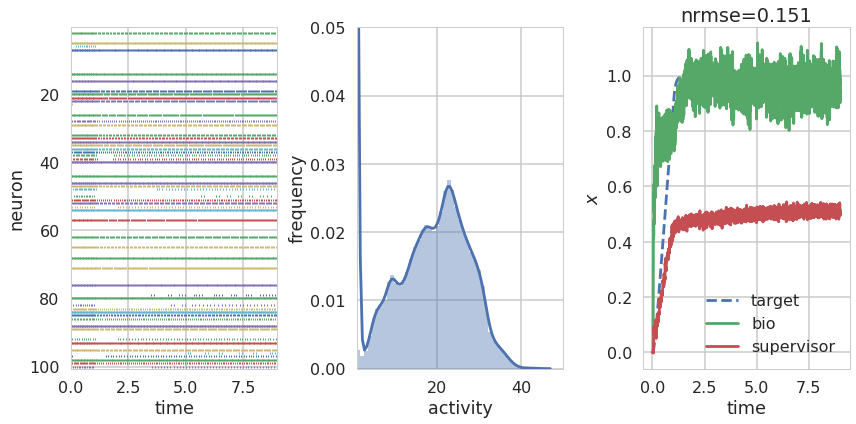

Building finished in 0:00:02.                                                   
Simulating finished in 0:35:52.                                                 


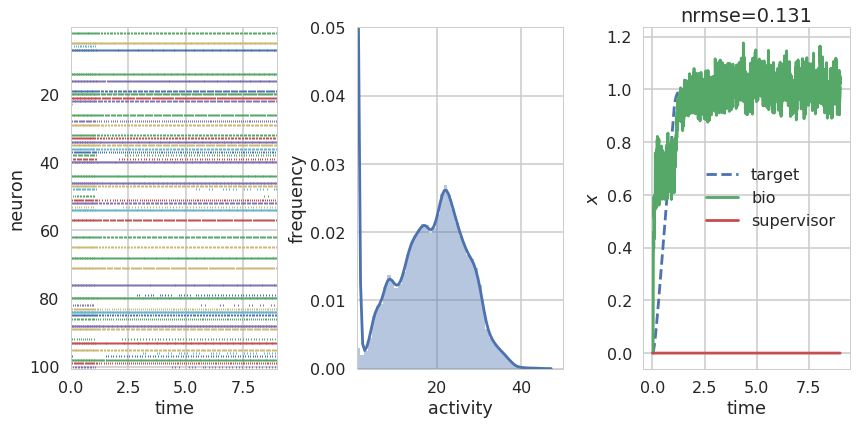

Building finished in 0:00:02.                                                   
Simulating finished in 0:35:32.                                                 


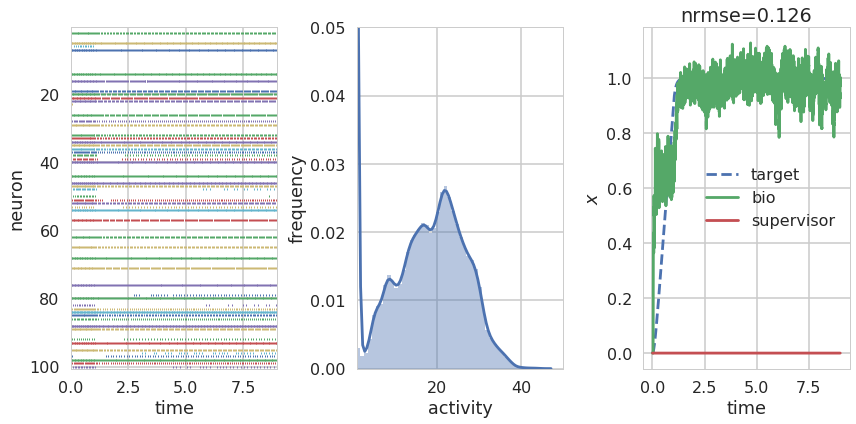

In [6]:
d_supv = supervisor(
    t=9,
    n=100,
    tau=0.01,
    signal='ramp_flat',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'))

d_bios = {}
for sec in d_supv:
    d_bios[sec] = copy.copy(d_supv[sec])
    
supvs = [1.0, 0.5, 0.0]
for supv in supvs:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=supv,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=+1,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))
    
sines = [+1]
for sine in sines:
    d_bios = simulate(
        d_supv,
        d_bios,
        supv=0.0,
        t=9,
        n=100,
        tau=0.1,
        signal='ramp_flat_integral',
        freq=8,
        sine=sine,
        secs=['tuft'],
        n_syns={'tuft': 1},
        regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
        gain=nengo.dists.Uniform(-1e2, 1e2),
        bias=nengo.dists.Uniform(-2e-4, 2e-4),
        neuron_type=BahlNeuron(bias_method='weights'))

Building finished in 0:00:02.                                                   
Simulating finished in 0:38:18.                                                 


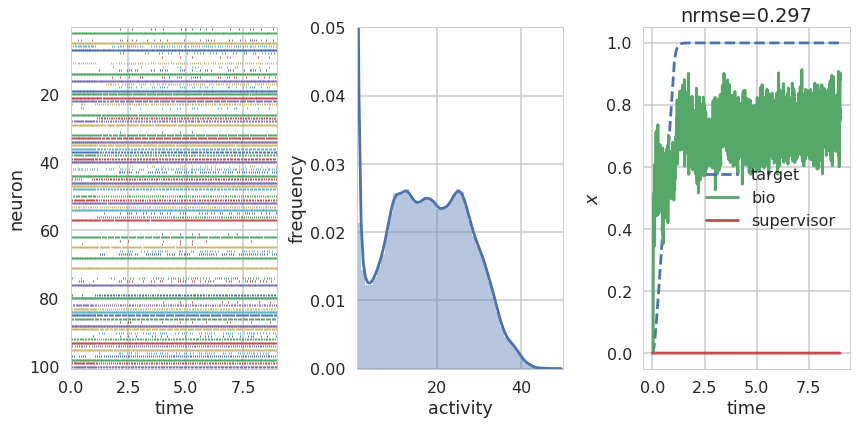

In [7]:
rng = np.random.RandomState(seed=1)
sigma_noise = 1e-4
syn_weights_noise = rng.normal(loc=0.0, scale=sigma_noise, size=(100, 100, 1))

_ = simulate(
    d_supv,
    d_bios,
    supv=0.0,
    t=9,
    n=100,
    tau=0.1,
    signal='ramp_flat_integral',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    noise_weights=syn_weights_noise,
    neuron_type=BahlNeuron(bias_method='weights'))

This distribution of noisy synaptic events has reduced the value that the bioneurons ramp to, but does not lead to accumulated degredation of performance. 

Building finished in 0:00:02.                                                   
Simulating finished in 0:38:29.                                                 


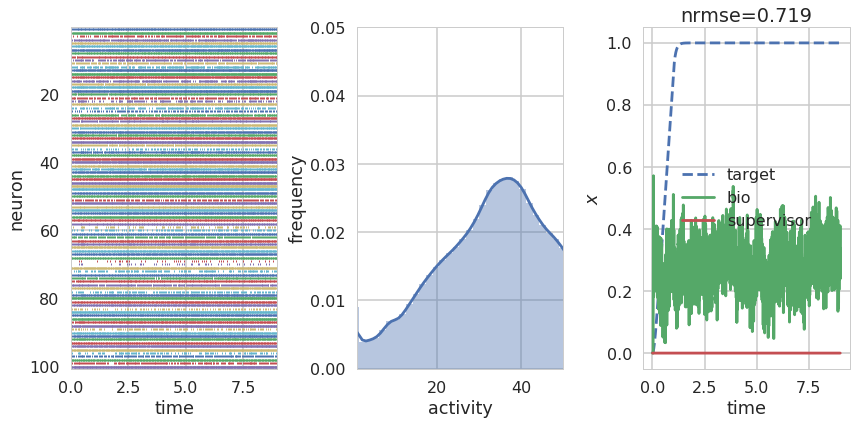

In [8]:
rng = np.random.RandomState(seed=1)
sigma_noise = 1e-3
syn_weights_noise = rng.normal(loc=0.0, scale=sigma_noise, size=(100, 100, 1))

_ = simulate(
    d_supv,
    d_bios,
    supv=0.0,
    t=9,
    n=100,
    tau=0.1,
    signal='ramp_flat_integral',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    noise_weights=syn_weights_noise,
    neuron_type=BahlNeuron(bias_method='weights'))

Increasing noise compounds these effects rather than leading to accumulating interference

Building finished in 0:00:02.                                                   
Simulating finished in 0:41:02.                                                 


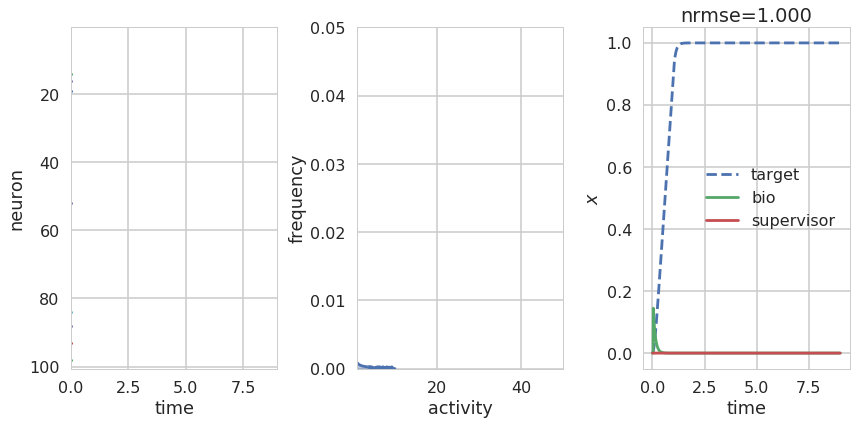

In [10]:
rng = np.random.RandomState(seed=1)
sigma_noise = 1e-2
syn_weights_noise = -1*np.abs(rng.normal(loc=0.0, scale=sigma_noise, size=(100, 100, 1)))

_ = simulate(
    d_supv,
    d_bios,
    supv=0.0,
    t=9,
    n=100,
    tau=0.1,
    signal='ramp_flat_integral',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    noise_weights=syn_weights_noise,
    neuron_type=BahlNeuron(bias_method='weights'))

Inhibitory synapses can dampen all activity if sufficiently strong

Building finished in 0:00:02.                                                   
Simulating finished in 0:44:15.                                                 


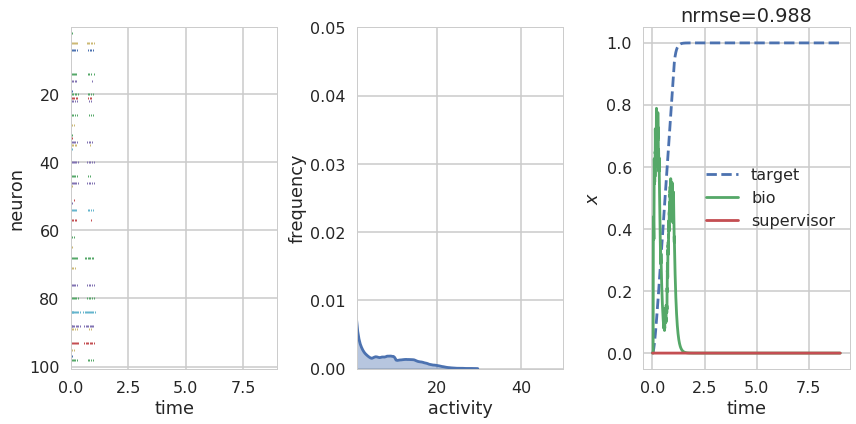

In [11]:
rng = np.random.RandomState(seed=1)
mu_noise = 1e-4
sigma_noise = 2e-4
syn_weights_noise = -1*np.abs(rng.normal(loc=mu_noise, scale=sigma_noise, size=(100, 100, 1)))

_ = simulate(
    d_supv,
    d_bios,
    supv=0.0,
    t=9,
    n=100,
    tau=0.1,
    signal='ramp_flat_integral',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    noise_weights=syn_weights_noise,
    neuron_type=BahlNeuron(bias_method='weights'))

Building finished in 0:00:02.                                                   
Simulating finished in 0:41:51.                                                 


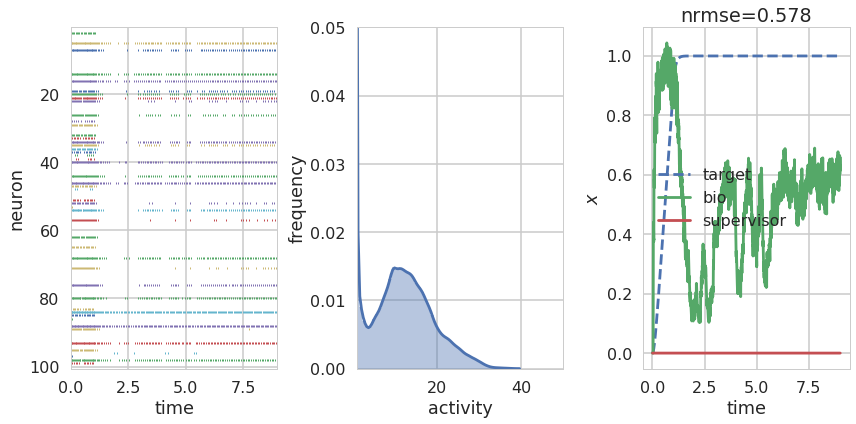

In [12]:
rng = np.random.RandomState(seed=1)
mu_noise = 5e-5
sigma_noise = 5e-5
syn_weights_noise = -1*np.abs(rng.normal(loc=mu_noise, scale=sigma_noise, size=(100, 100, 1)))

_ = simulate(
    d_supv,
    d_bios,
    supv=0.0,
    t=9,
    n=100,
    tau=0.1,
    signal='ramp_flat_integral',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    noise_weights=syn_weights_noise,
    neuron_type=BahlNeuron(bias_method='weights'))

Building finished in 0:00:02.                                                   
Simulating finished in 0:45:04.                                                 


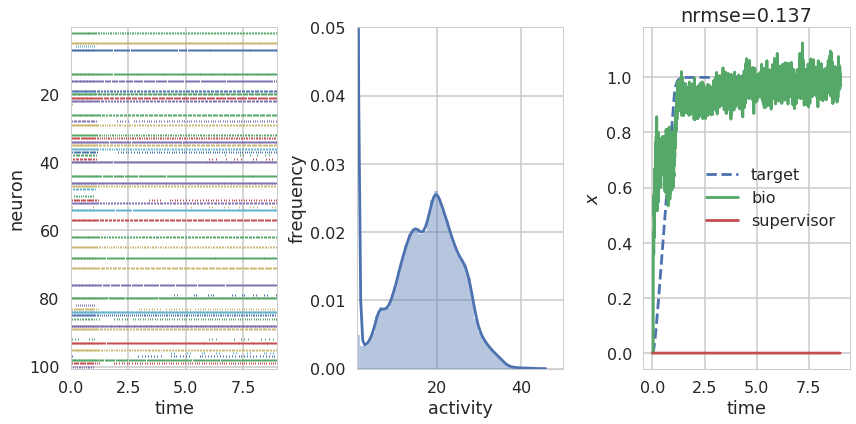

In [13]:
rng = np.random.RandomState(seed=1)
mu_noise = 1e-5
sigma_noise = 1e-5
syn_weights_noise = -1*np.abs(rng.normal(loc=mu_noise, scale=sigma_noise, size=(100, 100, 1)))

_ = simulate(
    d_supv,
    d_bios,
    supv=0.0,
    t=9,
    n=100,
    tau=0.1,
    signal='ramp_flat_integral',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    noise_weights=syn_weights_noise,
    neuron_type=BahlNeuron(bias_method='weights'))

In [ ]:
rng = np.random.RandomState(seed=1)
mu_noise = 2e-5
sigma_noise = 2e-5
syn_weights_noise = -1*np.abs(rng.normal(loc=mu_noise, scale=sigma_noise, size=(100, 100, 1)))

_ = simulate(
    d_supv,
    d_bios,
    supv=0.0,
    t=9,
    n=100,
    tau=0.1,
    signal='ramp_flat_integral',
    freq=8,
    sine=+1,
    secs=['tuft'],
    n_syns={'tuft': 1},
    regs={'tuft': 3.0, 'ff': 1.0, 'out': 0.1},
    gain=nengo.dists.Uniform(-1e2, 1e2),
    bias=nengo.dists.Uniform(-2e-4, 2e-4),
    noise_weights=syn_weights_noise,
    neuron_type=BahlNeuron(bias_method='weights'))

Building finished in 0:00:02.                                                   
[###########            Simulating... 18%                       ] ETA: 0:36:21